## Language Modeling I: BERT Text Classification

In this section, we will explore the powerful pretrained language model **BERT** (Bidirectional Encoder Representations from Transformers) and apply it to the task of text classification.

Through hands-on examples, we will see how it can be fine-tuned for specific tasks such as text classification.

Let's start!

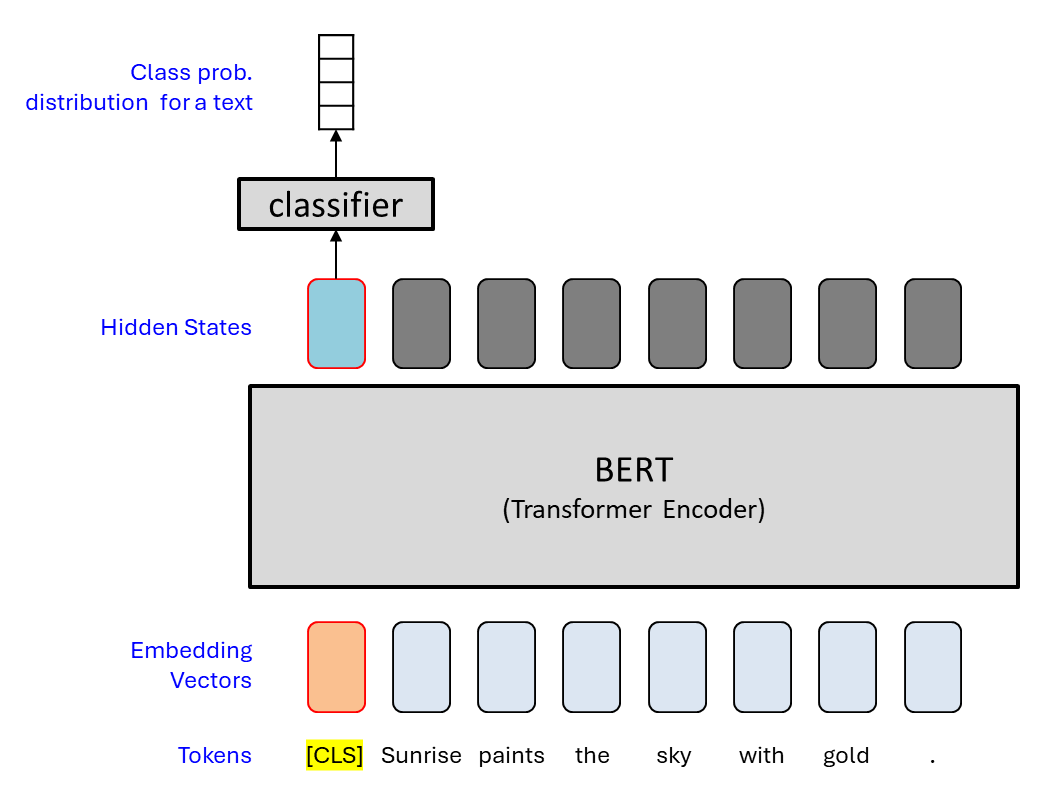

Let's install some libraries!


In [ ]:
!pip install -U datasets

In [ ]:
! pip install transformers accelerate evaluate scikit-learn

## Data Loading

For this text classification task, we will be using the **TeCla** dataset, which is specifically designed for multi-class text classification tasks in Catalan. TeCla is a large-scale, publicly available corpus that contains news articles from various domains, making it a great resource for training and evaluating language models on real-world text data.

### Dataset Overview

The **TeCla** dataset is hosted on Hugging Face under the identifier: `projecte-aina/tecla`. You can access it directly from the following link: [TeCla Dataset](https://huggingface.co/datasets/projecte-aina/tecla).

The current version of the dataset, **TeCla 2.0**, contains a total of **113,376 news articles** that have been carefully labeled for multi-class text classification. These articles are classified into a hierarchical class structure, with both **coarse-grained** and **fine-grained** categories.

- **Coarse-grained classes**: These represent high-level topics under which the articles are classified. There are four main coarse-grained categories:
  1. Politics
  2. Economy
  3. Society
  4. Culture
  
- **Fine-grained classes**: Each of the coarse-grained categories includes a set of more specific, fine-grained sub-categories. The dataset has a total of **53 fine-grained categories** that provide more detailed classification labels.

This hierarchical structure allows for both broad and granular classification, making it a versatile dataset for a variety of text classification challenges. The fine-grained labels enable more specific classification, which can be especially useful when we want to fine-tune the model to recognize nuanced distinctions in different types of news articles.

To get started with the dataset, we will load the TeCla data from Hugging Face using the `datasets` library.


In [ ]:
# Import the necessary function to load datasets from the 'datasets' library
from datasets import load_dataset

# Define the name of the dataset to be loaded.
# This dataset is hosted on Hugging Face Hub under the name "projecte-aina/tecla"
dataset_name = "projecte-aina/tecla"

# Load the specified dataset into a variable named 'tecla'.
# This function downloads the dataset from Hugging Face Hub and prepares it for use.
tecla = load_dataset(dataset_name)

# Display the basic information about the loaded dataset 'tecla'.
# This shows its structure, splits, and features, giving an overview of the dataset.
tecla

Explore the fields of the datasets for 10 random examples taken from the `test` split

In [ ]:
import random

# Get a random sample of 10 data points from the 'test' split of the dataset
tecla_test_random_sample = tecla["test"].shuffle(seed=42).select(range(10))

# Iterate through each data point in the sample
for example in tecla_test_random_sample:
    # Print all the fields (keys) and their corresponding values for each data point
    for field, value in example.items():
        print(f"{field}: {value}")
    print("-" * 20)  # Print a separator between data points

# Zero-Shot Classification with a Natural Language Inference Pretrained Model

Before fine-tuning, it is useful to explore zero-shot classification to understand how transformers perform without task-specific training. Zero-shot classification allows a model to classify text into categories it has never seen during training. This is possible using models trained for Natural Language Inference (NLI), such as `facebook/bart-large-mnli`. The `facebook/bart-large-mnli` model was specifically trained on datasets designed for NLI tasks, where the objective is to determine whether a given hypothesis can be inferred, contradicted, or is neutral with respect to a premise.

In zero-shot classification using a fine-tuned NLI model:
1. **Premise and Hypothesis Construction:** The input text to be classified is treated as the *premise*, while each candidate label is rephrased into a natural language *hypothesis* (e.g., "The text is about sports.").
2. **Inference Calculation:** The model predicts the probability that the hypothesis is entailed by the premise. If the hypothesis is highly probable, the model considers the label as likely for the input text.
3. **Label Scoring:** The model provides a score for each candidate label, and the label with the highest score is chosen as the predicted class.

**Recommendation:** To speed up inference and reduce computational cost, consider using only `label1` as the primary label candidate during testing.



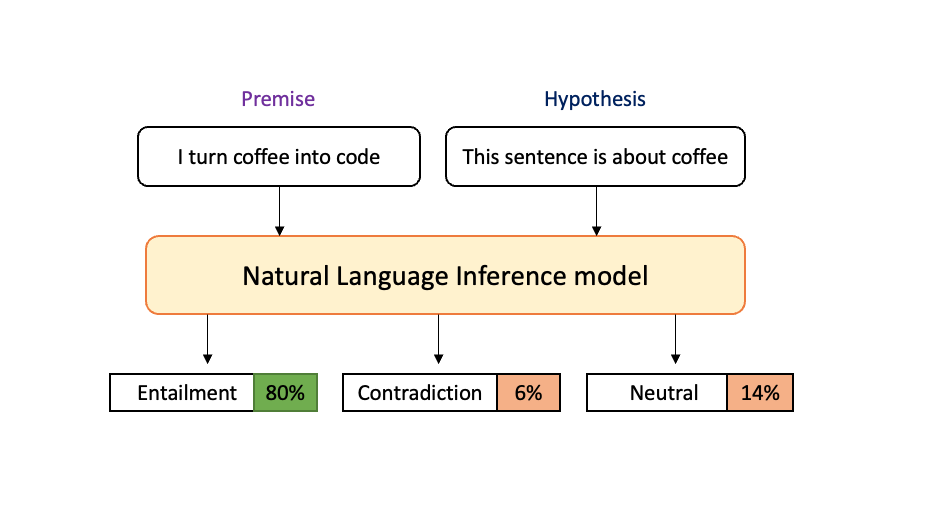

In [ ]:
from transformers import pipeline

# Zero-shot classification using pre-trained model
# TODO: Choose a model from the HF Models Hub that is best suited for handling Catalan sentence: https://huggingface.co/models.
# Hint: Search among fine-tuned models suitable for zero-shot text classification that may have trained on Catalan or at least multilingual data.
model_name =

classifier = pipeline("zero-shot-classification", model=model_name, device=0)

text = tecla["test"][1]["sentence"]
label = tecla["test"][1]["label1"]
labels = tecla["test"].unique("label1")

template = "Aquest article tracta sobre {}."

# TODO: Apply the classifier to get predictions
prediction =

# Inspect the predictoin object and understand it
prediction

Extract the prediction values and take the maximum value as the prediction.


In [ ]:
# TODO: Get the prediction with the highest score as the predicted label
# Hint: Extract the index of the maximum score
max_score =
max_score_index =

print("Sentence:", text)
print("Predicted Label:", prediction["labels"][max_score_index])
print("Label:", label)

## Fine-Tuning

In this section, we will demonstrate how to fine-tune a pretrained language model for the specific task of text classification. Fine-tuning involves adapting a general-purpose language model to perform well on a particular task by training it further on a dataset that is relevant to that task.

For this demonstration, we will use the **Catalan BERTa-v2** model, which is a variant of the BERT model specifically trained on Catalan text. The model is built on the **RoBERTa** architecture, which is an optimized version of BERT that removes the Next Sentence Prediction task and trains on more data for longer periods of time. The Catalan BERTa-v2 model is designed to work with the Catalan language, making it well-suited for applications involving text written in Catalan.

The specific model we are using is available on Hugging Face under the identifier: [projecte-aina/roberta-base-ca-v2](https://huggingface.co/projecte-aina/roberta-base-ca-v2). This model is pretrained on a large corpus of Catalan text, making it a great starting point for our task.

Fine-tuning this model for text classification will allow us to leverage its learned representations of Catalan text, adapting it to classify new text into predefined categories. We will walk through the steps to load the pretrained model, prepare the dataset, and perform the fine-tuning process to train it for classification tasks.

By fine-tuning a model like BERTa-v2, we can significantly improve the model's performance on domain-specific tasks with relatively small amounts of task-specific data, all while benefiting from the power of a large, general-purpose language model.


## Data Preparation

### Input Preparation: Tokenization, Truncation, and Padding

Before feeding the text into the model, we must preprocess it. This ensures that the input format aligns with the model's expectations and maintains consistency with the way it was originally trained. To do this, we load the tokenizer for the [projecte-aina/roberta-base-ca-v2](https://huggingface.co/projecte-aina/roberta-base-ca-v2) model, which will perform the necessary preprocessing steps. We use the `AutoTokenizer` class from Hugging Face, which automatically loads the correct tokenizer for the model.

We will apply the following steps to a specific example to observe their effects:  
- **Tokenization**: The text is split into subwords, which are converted into a list of indices (numbers). During training, these indices are transformed into tensors (high-dimensional arrays), which are the numerical representation that the model uses to process the text.  
- **Truncation**: The text is truncated to ensure it does not exceed the maximum input length of `roberta-base-ca-v2` (512 tokens). If the text exceeds this length, it is cut off to ensure the token limit is not exceeded.  
- **Padding**: Shorter texts are padded with special tokens called `<pad>`. This ensures that all texts in a batch have the same length, which improves efficiency in computation during training and inference.

This process ensures that the texts are properly prepared to be fed into the model in an efficient and consistent manner, maintaining the features that the model learned during its initial training.

In [ ]:
# Load the tokenizer for the pre-trained model.
# The tokenizer is used to convert text into numerical tokens that can be processed by the model.
from transformers import AutoTokenizer

# Load the tokenizer for the pre-trained model "projecte-aina/roberta-base-ca-v2".
tokenizer = AutoTokenizer.from_pretrained("projecte-aina/roberta-base-ca-v2")

Let's apply the tokenizer using its *default configuration* and inspect the results.

After tokenizing the text, you will encounter the following fields in the output:

- **`input_ids`**: A list of token indices representing the tokenized text. Each index corresponds to a token from the model's vocabulary.
- **`attention_mask`**: A list of binary values (1s and 0s) indicating whether a token should be attended to. Tokens with a value of `1` are actual content tokens that the model should focus on, while tokens with a value of `0` are padding tokens, which are ignored during processing.

Let's check these fields to understand the structure of the tokenized input and how the model will process the text.


In [ ]:
# Tokenize a sentence from the dataset
text = tecla["test"][1]["sentence"]
example_tokenized = tokenizer(text)

print(example_tokenized)
print(len(example_tokenized["input_ids"]))

**Note**: the output of the previous cell should have raises a warning:

```
Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors
```

This indicates the the text is longer than the maximum model lenght, that is the default length used to pretrain the model.


Now, apply the tokenizer to perform *truncation to max length at 10 and padding*. Notice the difference with the default configuration!

In [ ]:
text = tecla["test"][1]["sentence"]

# TODO: apply padding and trucantion to maximum lenght at 10.
# Hint: look at the arguments of the tokenizer.
example_tokenized =

print(example_tokenized)
print(len(example_tokenized["input_ids"]))


Once we have the token indexes, we can always decode back the original text. Note that, by default, the tokenizer adds the special tokens required by the RoBERTa model, that are:

Show the special tokens of the RoBERTa model:

- `bos_token`: `<s>` (Beginning of sentence token)  
- `eos_token`: `</s>` (End of sentence token)  
- `unk_token`: `<unk>` (Unknown token)  
- `sep_token`: `</s>` (Separator token)  
- `pad_token`: `<pad>` (Padding token)  
- `cls_token`: `<s>` (Classification token)  
- `mask_token`: `<mask>` (Mask token)


We can decide to decode the original text with or without such special tokens.

In [ ]:
# Decode original text with special tokens
tokenizer.decode(example_tokenized['input_ids'])

In [ ]:
# Decode original text without special tokens
tokenizer.decode(example_tokenized["input_ids"], skip_special_tokens=True)

Let's apply all the preprocessing steps discussed earlier to the entire dataset using a preprocessing function and the `map` method from the `datasets` library. To accelerate the process, you can set `batched=True`, which enables the `map` method to process multiple elements simultaneously, significantly improving efficiency. For a deeper understanding of the available arguments and their usage, refer to the official documentation of the `map` method.

In [ ]:
def preprocess(example):
  """
  Preprocesses a single example by tokenizing the "sentence" using the pre-trained tokenizer.

  Args:
    example: A dictionary containing the sentence to be preprocessed.

  Returns:
    A dictionary containing the tokenized input IDs, attention mask, and token type IDs.
  """
  # Tokenize the sentence in the example using the pre-trained tokenizer.
  # Truncate the sentence if it exceeds the maximum length (512 tokens).
  # Pad the sentence if it is shorter than the maximum length.
  return tokenizer(example["sentence"], truncation=True, padding=True, max_length=512)

# Apply the preprocess function to the "tecla" dataset.
# The batched=True argument ensures that the preprocess function is applied to the dataset in batches, which can significantly improve performance.
tokenized_tecla = tecla.map(preprocess, batched=True)

# Show the result
tokenized_tecla

## Label Preparation

Next, we need to prepare the labels to ensure they are compatible with the model. Since transformer models expect numerical labels rather than string-based ones, we must convert the labels into integers.

To achieve this, we will create a **mapping** between the label names and their corresponding numerical IDs using two dictionaries:  

- **`label2id`**: Maps each label name to a unique integer identifier.  
- **`id2label`**: Performs the reverse mapping, converting numerical IDs back to their original label names.  

This dual mapping is essential for both training and inference:  
- During **training**, the model will use `label2id` to process the numerical representation of the labels.  
- During **inference**, the model can convert predicted IDs back into human-readable label names using `id2label`.  

Let’s implement the conversion process to prepare the dataset for training.

In [ ]:
# We use the labels from the "train" split
labels = tecla["train"].unique("label1")

# TODO: Create label-to-id and id-to-label mapping using python dictionary
label2id =
id2label =

# Check the mapping
print(label2id)
print(id2label)

Create a label mapping function to use with the `map` method, like before


In [ ]:
def convert_label_to_int(example):
    """
    Converts the labels in an example from string format to integer format.

    Args:
        example: A dictionary containing the labels to be converted.

    Returns:
        A dictionary containing the converted labels.
    """
    # Convert the 'label1' key in the example to integers using the label2id dictionary.
    # This ensures that the labels are in a numerical format that can be used by the model.
    example['label1'] = [label2id[label] for label in example['label1']]
    return example

# Apply the convert_label_to_int function to the tokenized_tecla dataset.
# This converts the labels in the dataset from string to integer format.
# batched=True ensures that the function is applied in batches, improving performance.
# desc provides a description of the operation for progress tracking.
tokenized_tecla = tokenized_tecla.map(convert_label_to_int, batched=True, desc="Processing labels..")

# Display the processed tokenized_tecla dataset.
tokenized_tecla

Finally, we will use the `label_1` column from the dataset and rename it to the standard column name `label`. Standardizing the label name is crucial because most Hugging Face models are designed to look specifically for a column named `label` when fine-tuning for classification tasks. Using a different name could lead to errors or the model failing to recognize the labels correctly during training.

Renaming the column ensures the model can automatically identify the labels without requiring additional configuration adjustments.

**Important**:  
The model only requires the following columns for fine-tuning:  
- **`input_ids`**: The list of token indices generated by the tokenizer.  
- **`attention_mask`**: A list indicating which tokens should be attended to (1 for real tokens, 0 for padding).  
- **`label`**: The numerical representation of the class label for each example.  

All other columns in the dataset will be ignored during the fine-tuning process. Therefore, it’s recommended to remove any unnecessary columns after preprocessing to avoid confusion and reduce memory usage during training.

In [ ]:
# Iterate over each split (e.g., 'train', 'test', 'validation') in the tokenized_tecla dataset.
for split in tokenized_tecla.keys():
  # Rename the 'label1' column to 'label' for consistency in each split.
  tokenized_tecla[split] = tokenized_tecla[split].rename_column("label1", "label")
  # Remove the original 'sentence' and 'label2' columns as they are no longer needed.
  tokenized_tecla[split]  = tokenized_tecla[split].remove_columns(
    ["sentence", "label2"]
)

# Display the updated tokenized_tecla dataset.
tokenized_tecla

## Evaluation

Before starting the training process, it is important to include a metric that will help us evaluate the performance of the model throughout the training. Having an evaluation metric allows us to track the model’s progress and make sure it is learning effectively.

To quickly integrate an evaluation method, we can use the `evaluate` library. This library provides a simple way to load and use a variety of evaluation metrics. For this specific task, we will load the **accuracy** metric from the `evaluate` library, which is commonly used to measure how often the model's predictions match the true labels.

Using accuracy as the evaluation metric, we can monitor how well the model performs on the validation or test set after each training epoch. This allows us to make adjustments or stop training if the model starts to overfit or if its performance plateaus.


In [ ]:
# Import the 'evaluate' library, which provides tools for evaluating machine learning models.
import evaluate

# Load the 'accuracy' metric from the 'evaluate' library.
# This metric will be used to calculate the accuracy of the model's predictions.
accuracy = evaluate.load("accuracy")

Next, create a function called `compute_metrics` that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) and returns the accuracy score.


In [ ]:
# Import the NumPy library for numerical operations, particularly for working with arrays.
import numpy as np

def compute_accuracy(eval_pred):
  """
  Computes the accuracy of the model's predictions.

  Args:
    eval_pred: A tuple containing the model's predictions and the true labels.

  Returns:
    A dictionary containing the accuracy score.
  """
  # Extract predictions and labels from eval_pred.
  predictions, labels = eval_pred
  # Get the predicted class by finding the index of the highest probability for each prediction.
  predictions = np.argmax(predictions, axis=1)
  # Compute and return the accuracy using the accuracy metric.
  return accuracy.compute(predictions=predictions, references=labels)

## Training

Now, we will fine-tune our model for the text classification task by adding a classification layer on top of the pre-trained model. Fine-tuning allows the model to adapt to the specific task and learn to classify text based on the provided labels.

To do this, we create a classification layer using the [`AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/model_doc/auto) class from the Hugging Face `transformers` library. This class is designed for sequence classification tasks and can be easily adapted to work with pre-trained models.

When creating the model, we define the number of labels (classes) and provide the label-to-ID mapping. This enables the model to learn how to map the predicted outputs to the appropriate class labels during training and inference.

By using this approach, we leverage the power of a pre-trained model while adapting it to our specific classification problem.


In [ ]:
# Import the AutoModelForSequenceClassification class from the transformers library.
# This class is used to load a pre-trained model for sequence classification.
from transformers import AutoModelForSequenceClassification

# Load the pre-trained model "projecte-aina/roberta-base-ca-v2" for sequence classification.
model = AutoModelForSequenceClassification.from_pretrained("projecte-aina/roberta-base-ca-v2",
                                                           num_labels=len(labels), # num_labels specifies the number of output labels for the classification task.
                                                           label2id=label2id, # # label2id and id2label dictionaries map between labels and their corresponding IDs.
                                                           id2label=id2label)

Check the model configuration and get familiar with all the fields, such as label-related, model-related and similar.

In [ ]:
model.config

We define the hyperparameters using [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). This step is crucial for setting up the training strategy and configuration.

In this configuration, we specify that the model will be trained for 1000 steps. Additionally, the model will be evaluated on the validation dataset every 100 steps to monitor its performance during training. We also configure the saving of checkpoints at regular intervals to allow us to resume training if needed and keep track of the model's progress over time.

By defining these hyperparameters, we control the training process, including how often to evaluate, how many steps to train, and how to save checkpoints, ensuring an efficient and organized training workflow.


In [ ]:
# Import the TrainingArguments class from the transformers library.
# This class is used to define the hyperparameters for training a transformer model.
from transformers import TrainingArguments

# Define the training arguments for the model.
training_args = TrainingArguments(
    output_dir="tecla_model", # Directory to save the trained model.
    eval_strategy="steps", # Evaluate the model at specified intervals (steps).
    save_strategy="steps", # Save the model at specified intervals (steps).
    save_steps=100, # Save the model every 100 steps.
    eval_steps=100, # Evaluate the model every 100 steps.
    max_steps=1000, # Total number of training steps.
    logging_steps=10,  # Log training information every 10 steps.
    num_train_epochs=1, # Number of training epochs (one full pass over the training data).
    learning_rate=2e-5, # Learning rate for the optimizer.
    per_device_train_batch_size=10, # Batch size for training on each device.
    per_device_eval_batch_size=10, # Batch size for evaluation on each device.
    logging_dir='tecla_model/logs', # Directory to save training logs.
    report_to="tensorboard") # Enable Tensorboard reporting

Inspect all the training arguments, including defualt ones, and get familiar with them. You will see a lot of them. They are fundamental to control the training loop.

In [ ]:
training_args

Now, pass the training arguments to the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, and the `compute_metrics` function. The `Trainer` class simplifies the training process by managing most of the training loop internally.

The following arguments are passed to the `Trainer`:

- **`model`**:
  - The pre-trained model that will be fine-tuned. This model (e.g., `projecte-aina/roberta-base-ca-v2`) will be used for the sequence classification task.

- **`args`**:
  - The training arguments, which are defined using the `TrainingArguments` class. These arguments determine how the training proceeds, such as how often the model should be evaluated, the save strategy, the batch size, the learning rate, and more.

- **`train_dataset`**:
  - The dataset used for training. This is typically the processed training data (e.g., `dataset['train']`) that the model will learn from.

- **`eval_dataset`**:
  - The validation dataset, used to evaluate the model at intervals during the training process. It allows us to track the model's performance and prevent overfitting.

- **`tokenizer`**:
  - The tokenizer used to preprocess text data. It converts raw text into tokens that the model can understand. The tokenizer ensures that text is processed in the same way it was when the model was pre-trained.

- **`compute_metrics`**:
  - A function that computes the evaluation metrics, such as accuracy. This function will be used by the `Trainer` during validation to calculate the model’s performance based on the predictions and the true labels.

Once all these arguments are passed to the `Trainer`, you can call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to start fine-tuning the model. This method will begin the training process using the defined settings, iterating over the dataset and updating the model weights based on the defined optimization and evaluation strategy.



In [ ]:
# Prevent potential CUDA error.
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
# Import the Trainer class from the transformers library.
from transformers import Trainer

trainer = Trainer(
# TODO: Initialize the Trainer with the specified arguments.
    model=
    args=
    train_dataset=
    eval_dataset=
    tokenizer=
    compute_metrics=


Finally, start the training and monitor it with the tensorboard!

In [ ]:
# Load the TensorBoard extension for visualizing training progress.
%load_ext tensorboard

# Start TensorBoard and point it to the log directory.
# Replace './logs' with the actual path to your log directory.
%tensorboard --logdir ./tecla_model/logs

# Begin training the model using the Trainer instance.
# This will also log data to TensorBoard for visualization.
trainer.train()

## Inference

Now, let's perform inference using the [pipeline](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline) abstraction on the same zero-shot example from TeCla, utilizing the fine-tuned models.

The `pipeline` API simplifies the process of making predictions with pre-trained models. It handles the input data, model inference, and outputs the results in an easy-to-understand format. For text classification, we can use the pipeline to predict the class of a given text, even without explicitly writing the model inference code.

When performing inference in a zero-shot setting (without retraining the model on specific classes), we can pass text directly to the pipeline, and it will return predictions. This allows us to apply the fine-tuned model to new, unseen examples and classify them accordingly.

Unlike the previous inference in zero-shot setting, in this case, we will use the model we just trained (fine-tuned on TeCla) and apply it to a new sample, utilizing the pipeline abstraction to make predictions efficiently.







In [ ]:
# Import the pipeline function for easy model inference.
from transformers import pipeline

# Specify the path to the fine-tuned model checkpoint.
model_finetuned = "/content/tecla_model/checkpoint-100"

# Create a text classification pipeline using the fine-tuned model.
# device=0 indicates using the first available GPU.
classifier = pipeline("text-classification", model=model_finetuned, device=0)

# Get a test sentence and its true label from the 'tecla' dataset.
# Assuming 'tecla' is a dictionary containing the test data.
text = tecla["test"][0]["sentence"]
label = tecla["test"][0]["label1"]

# Perform prediction on the first 1000 characters of the sentence. This is necessary because sentences could exceed the maximum model length
prediction = classifier(text[:1000])[0]['label']

# Print the original sentence, predicted label, and true label.
print("Sentence:", text)
print("Predicted Label:", prediction)
print("Label:", label)

# Exercise 1

## Objective:

Create a batch of examples using [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorWithPadding). This approach dynamically pads the sentences to the longest sequence in a given batch during collation, which is more efficient than padding the entire dataset to a fixed maximum length. By doing this, you avoid excessive padding, reduce memory usage, and speed up the training process, as each batch only gets padded to the necessary length.


## Suggestion:
The `data_collator` is passed as an argument to the `Trainer`.


In [ ]:
# Import the Trainer class from the transformers library.
from transformers import Trainer

# TODO: import the data collator with padding
# Create a data collator for padding sequences in a batch.

# Initialize the Trainer using data_collator and all the other arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_tecla["train"],
    eval_dataset=tokenized_tecla["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy,
# TODO: Initialize the Trainer using data_collator
    data_collator=

)

# Load the TensorBoard extension for visualizing training progress.
%load_ext tensorboard

# Start TensorBoard and point it to the log directory.
# Replace './logs' with the actual path to your log directory.
%tensorboard --logdir ./tecla_model/logs

# Begin training the model using the Trainer instance.
# This will also log data to TensorBoard for visualization.
trainer.train()

# Exercise 2

## Objective:
Implement the F1 score as the validation metric instead of accuracy during training.

## Suggestion:
Use the `compute_accuracy` function as a reference.

In [ ]:
# Import the 'evaluate' library, which provides tools for evaluating machine learning models.
import evaluate
# Import the NumPy library for numerical operations, particularly for working with arrays.
import numpy as np

# TODO: Load the 'f1' metric from the 'evaluate' library.
# This metric will be used to calculate the accuracy of the model's predictions.
f1 =

# TODO: Implement the F1 metric
  # Extract predictions and labels from eval_pred.
    # Get the predicted class by finding the index of the highest probability for each prediction.
    # Compute and return the accuracy using the accuracy metric.


Now, start the training with the F1 metric as evaluation.

In [ ]:
# Import the Trainer class from the transformers library.
from transformers import Trainer

# Initialize the Trainer using data_collator and all the other arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_tecla["train"].select(range(10)),
    eval_dataset=tokenized_tecla["validation"].select(range(10)),
    tokenizer=tokenizer,
    compute_metrics=compute_f1,
)

# Load the TensorBoard extension for visualizing training progress.
%load_ext tensorboard

# Start TensorBoard and point it to the log directory.
# Replace './logs' with the actual path to your log directory.
%tensorboard --logdir ./tecla_model/logs

# Begin training the model using the Trainer instance.
# This will also log data to TensorBoard for visualization.
trainer.train()
